In [1]:
import pandas_datareader as pdr 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [2]:
key = 'ad886a8cae248c00a0603a57a777ac027b11c3a3'
df = pdr.get_data_tiingo('NFLX', api_key = key)
df.to_csv('NFLX.csv')


In [3]:
df = pd.read_csv('NFLX.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,NFLX,2016-07-20 00:00:00+00:00,87.91,88.49,85.82,86.67,23525141,87.91,88.49,85.82,86.67,23525141,0.0,1.0
1,NFLX,2016-07-21 00:00:00+00:00,85.99,88.38,85.21,88.30,16083996,85.99,88.38,85.21,88.30,16083996,0.0,1.0
2,NFLX,2016-07-22 00:00:00+00:00,85.89,86.50,85.11,86.48,11363917,85.89,86.50,85.11,86.48,11363917,0.0,1.0
3,NFLX,2016-07-25 00:00:00+00:00,87.66,87.87,85.01,85.73,14135027,87.66,87.87,85.01,85.73,14135027,0.0,1.0
4,NFLX,2016-07-26 00:00:00+00:00,91.41,93.10,90.90,91.03,19577623,91.41,93.10,90.90,91.03,19577623,0.0,1.0


In [4]:
df1 = df.reset_index()['close']
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,NFLX,2021-07-12 00:00:00+00:00,537.31,540.6497,532.92,540.30,1780738,537.31,540.6497,532.92,540.30,1780738,0.0,1.0
1253,NFLX,2021-07-13 00:00:00+00:00,540.68,545.3300,535.76,535.76,2751593,540.68,545.3300,535.76,535.76,2751593,0.0,1.0
1254,NFLX,2021-07-14 00:00:00+00:00,547.95,554.1000,541.01,541.01,4659535,547.95,554.1000,541.01,541.01,4659535,0.0,1.0
1255,NFLX,2021-07-15 00:00:00+00:00,542.95,557.5399,538.20,553.97,5713873,542.95,557.5399,538.20,553.97,5713873,0.0,1.0
1256,NFLX,2021-07-16 00:00:00+00:00,530.31,544.0600,527.05,541.81,3442101,530.31,544.0600,527.05,541.81,3442101,0.0,1.0


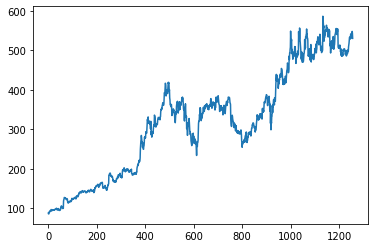

In [5]:
plt.plot(df1)

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 295ms/step - loss: 0.0425 - val_loss: 0.0811
Epoch 2/100
12/12 [==============================] - 2s 187ms/step - loss: 0.0097 - val_loss: 0.0050
Epoch 3/100
12/12 [==============================] - 2s 187ms/step - loss: 0.0044 - val_loss: 0.0197
Epoch 4/100
12/12 [==============================] - 2s 189ms/step - loss: 0.0024 - val_loss: 0.0121
Epoch 5/100
12/12 [==============================] - 2s 188ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 6/100
12/12 [==============================] - 2s 189ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 7/100
12/12 [==============================] - 2s 184ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 8/100
12/12 [==============================] - 2s 189ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 9/100
12/12 [==============================] - 2s 187ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 10/100
12/12 [==============================] - 2s 187ms/step - loss: 0.0015 - val_lo

In [15]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [16]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
math.sqrt(mean_squared_error(y_train,train_predict))

279.8907988544223

In [17]:
math.sqrt(mean_squared_error(ytest,test_predict))

469.17507621634354

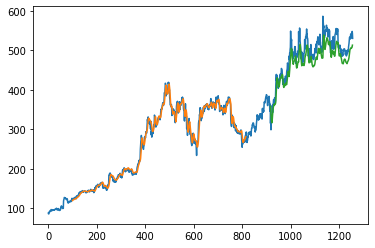

In [18]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [19]:
len(test_data)

440

In [20]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()


In [25]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

ValueError: ignored

In [ ]:
day_new=np.arange(101)
day_pred=np.arange(101,131)

In [ ]:

plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:

df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)